In [1]:
from __future__ import division
%matplotlib inline
import numpy as np
from scipy.signal import find_peaks_cwt
import matplotlib.pyplot as plt
import peakutils
import pandas as pd
from itertools import groupby
import requests
import datetime

In [2]:
%matplotlib inline

from __future__ import division
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib
import matplotlib.pyplot as plt
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from nltk.util import ngrams as nltk_ngrams
from collections import Counter
import networkx as nx

custom_stopwords = ['rt', '&amp', '#', '', '&amp;', '-', 'amp', '.', 'QQQQQQQQQ', 'll','re','ve']
stopwords_english = stopwords.words('english')
stopwords_spanish = stopwords.words('spanish')
tknzr = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
def is_word_blacklisted(word):
    return word.startswith('http') or \
           word.startswith('//') or \
           word.startswith('@') or \
           word.startswith('#') or \
           word in custom_stopwords or \
           word in stopwords_english 


def clean_text(text, remove_non_chars=True): 
    words = text.split()
    for i in range(len(words)):
        word_with_no_ht = words[i].replace('#','')
        if words[i][0] == '#' and words_cnt[word_with_no_ht] >  len(data_raw)*0.001:
            words[i] = word_with_no_ht
                
    new_text = ' '.join(words)
    
    new_text = re.sub(r'@\S+', '', new_text)
    new_text = re.sub(r'#\S+', '', new_text)
    new_text = re.sub(r',', '.', new_text)
    new_text = re.sub(r"'", ' ', new_text)
    new_text = re.sub(r'https://\S+', '', new_text)
    new_text = re.sub(r'http://\S+', '', new_text)
    words = tknzr.tokenize(new_text)

    if remove_non_chars:
        words = [re.sub(r'\W+', ' ', w) for w in words]

    return ' '.join([w for w in words if not is_word_blacklisted(w)])

def find_all_paths(G):
    result = []
    try:
        result = []
        start_nodes = [k for k,v in G.in_degree().iteritems() if v == 0]

        for start in start_nodes:
            paths = nx.shortest_path(G, start)
            longest = max(paths, key= lambda x: len(set(paths[x])))
            result.append(paths[longest])
    except Exception as e:
        logging.info("Error, " + e.message)

    return result

def get_path_tuple(p, l):
    d= dict(l)
    prev = p[0]
    sum = 0
    count = 0
    min_cnt = 9999999
    min_term = ''
    phrase = p[0].split()[0]
    for i in range(1, len(p)):
        terms  = (prev + ' ' + p[i]).split()
        term = terms[0] + ' ' + terms[1] + ' ' + terms[3]

        if term in d:
            cnt = d[term]

            if cnt < min_cnt:
                min_cnt = cnt
                min_term = term

            count+=1
            sum += cnt

        prev = p[i]
        phrase += ' ' + p[i].split()[0]

    phrase += ' ' +  p[-1].split()[1]
    return phrase, min_cnt, min_term

def build_phrases_from_aggs(ngram_hash,aggs):
    l = sorted(aggs, key=lambda x: x[1], reverse=True)

    G = nx.DiGraph()
    for i in range(len(l)):

        bgram = l[i][0]
        count = l[i][1]
        terms = bgram.split()

        term1 = terms[0] + ' ' + terms[1]
        term2 = terms[1] + ' ' + terms[2]

        G.add_edge(term1, term2, weight=count)

    paths = find_all_paths(G)
    phrases = [get_path_tuple(p,l) for p in paths]

    keys = list(set([x[2] for x in phrases]))
    d = [( k , [(x[0],x[1]) for x in phrases if x[2] == k]) for k in keys]

    result = [{'phrase' : v[0][0], 'count' : v[0][1], 'alias' : k, 'tweets' : ngram_hash[k]} for k,v in dict(d).iteritems()]


    return sorted(result, key=lambda x : x['count'], reverse=True)


def get_grams(text):
    return [ ' '.join(g) for g in nltk_ngrams(text.split(),3)]

def get_cluster_phrases(cluster_tweets):
    ngrams_hash = {}
    cnt = Counter()
    for i in range(len(cluster_tweets)):
        t = cluster_tweets[i]
        grams = get_grams(t)
        
        for gram in grams:
            if gram not in ngrams_hash:
                ngrams_hash[gram] = []
                
            ngrams_hash[gram].append(i)
        
        cnt.update(get_grams(t))
    return build_phrases_from_aggs(ngrams_hash, cnt.most_common(int(np.sqrt(len(cluster_tweets)))))[:50]
    #return build_phrases_from_aggs(cnt.most_common(int(50)))[:30]

    
def distance(p1,p2):
    if p1 in p2 or p2 in p1:
        return 0
        
    p1 = set(p1.split())
    p2 = set(p2.split())
    
    
    union = p1.union(p2)
    inter = p1.intersection(p2)
    
   
    return 1 - (len(inter)/len(union))
    
    
    
def merge_close_phrases(phrases):
    
    new_phrases = []
    
    for p1 in phrases:
        new_p = p1['phrase']
        new_p_count = p1['count']
        new_p_tweets = p1['tweets']
        for p2 in phrases:
            if p1 != p2 and distance(p1['phrase'],p2['phrase']) < 0.6:
                new_p_count += p2['count']
                
        new_phrases.append({'phrase' : new_p, 'count' : new_p_count, 'tweets' : new_p_tweets  })
        
    return new_phrases
                
                

def find_peaks(cb):
    indexes = peakutils.indexes(cb,thres=0.5,min_dist=50)

    peaks = []
    for peak_i in indexes:

        not_found = True
        prev_i = peak_i
        while not_found:
            curr_i = prev_i - 1

            if curr_i > 0 and cb[curr_i] > cb[prev_i] and cb[curr_i] < 0.5*cb[peak_i]: 
                
                peaks.append((prev_i,peak_i))
                not_found = False
            elif curr_i <=0:
                peaks.append((prev_i,peak_i))
                not_found = False

            prev_i = curr_i

    return peaks

def parse_date(date):
    year = int(date[:4])
    month = int(date[4:6])
    day = int(date[6:8])
    hour = int(date[8:10])
    
    
    return datetime.datetime(year,month,day,hour)

def date_to_str(d):
    year = d.year
    month = d.month
    day = d.day
    hour = d.hour
    
    return '%d%s%s%s00' % (year, format(month,'02'), format(day,'02'), format(hour,'02'))
    

def get_hour_pages(fromDate, toDate):
    
    pages = []
    
    fromDate = parse_date(fromDate)
    toDate = parse_date(toDate)
    
    
    total_hours = int((toDate - fromDate).seconds/60/60)
    print total_hours
    delta = int(total_hours/20)
    if delta == 0: delta = 1
    
    currFrom = fromDate
    currTo = fromDate + datetime.timedelta(hours=1)
    
    
    while currFrom < toDate:
        fromStr = date_to_str(currFrom)
        toStr = date_to_str(currTo)
        
        pages.append((fromStr, toStr))
        
        currFrom += datetime.timedelta(hours=delta)
        currTo = currFrom + datetime.timedelta(hours=1)
        
    return pages
        
def get_tweets(query, fromDate, toDate):

    payload = {
                'query'     : query,
                'maxResults': 500,
                'fromDate'  : fromDate,
                'toDate'  : toDate,
            }    
    url = ''
    user = ''
    password = ''
    r = requests.get(url, params=payload, auth=(user, password))
    res = r.json()
    
    pages = get_hour_pages(fromDate, toDate)
    results = res['results']
    
    num_of_pages = 0
    for page in pages:
        print page
        payload = {
            'query'     : query,
            'maxResults': 500,
            'fromDate'  : page[0],
            'toDate'  : page[1],
        }   
        
        
        r = requests.get(url, params=payload, auth=(user, password))
        res = r.json()
        results += res['results']
        
        pages_for_hour = 2
        while 'next' in res and pages_for_hour > 0:
            print pages_for_hour
            payload['next'] = res['next']
            
            r = requests.get(url, params=payload, auth=(user, password))
            res = r.json()
            results += res['results']
            pages_for_hour -= 1
               
        num_of_pages += 1
        
        if num_of_pages > 20: break
        
        
    
    return results

def get_counts(query, fromDate, toDate):
    
    payload = {
                'query'     : query,
                'bucket'    : 'hour',
                'fromDate'  : fromDate,
                'toDate'  : toDate,
            }
    url = ''
    user = ''
    password = ''
    r = requests.get(url, params=payload, auth=(user, password))
    
    t = r.text
    j = r.json()
    if 'results' not in j:
        print t

    results = sorted(j['results'], key=lambda x: x['timePeriod'])
    time_data = np.array([r['count'] for r in results])
    
    return time_data, results

In [107]:
time_data, results  = get_counts('(turkey OR istanbul) vpn lang:en', '201606260000','201606291000')

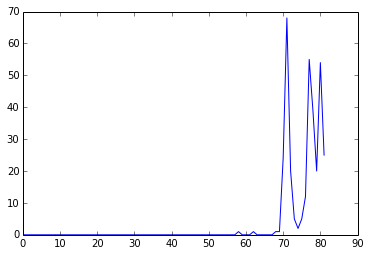

In [108]:
plt.plot(time_data)

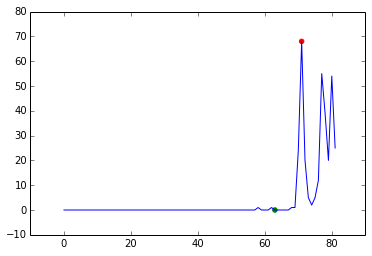

In [109]:
peaks = find_peaks(time_data)
peak_starts = [p[0] for p in peaks]
peak_ends = [p[1] for p in peaks]
plt.plot(time_data)
plt.scatter(peak_starts, [time_data[i] for i in peak_starts ],color='g')
plt.scatter(peak_ends, [time_data[i] for i in peak_ends ],color='r')

In [110]:
for i in range(len(peaks)):
    peak_number = i+1
    fromDate = results[peaks[i][0]]['timePeriod']
    toDate = results[peaks[i][1]]['timePeriod']
    number_of_tweets = sum(time_data[peaks[i][0]-1:peaks[i][1]+1])
    
    
    print 'Peak %d: from: %s, to: %s, number_of_tweets:%d' % (peak_number,fromDate,toDate,number_of_tweets)

Peak 1: from: 201606281500, to: 201606282300, number_of_tweets:95


In [89]:
get_hour_pages('201606121300','201606121900')

6


[('201606121300', '201606121400'),
 ('201606121400', '201606121500'),
 ('201606121500', '201606121600'),
 ('201606121600', '201606121700'),
 ('201606121700', '201606121800'),
 ('201606121800', '201606121900')]

In [5]:
tweets = get_tweets('(istanbul OR turkey) vpn lang:en', '201606260000','201606291000')
len(tweets)

10
('201606260000', '201606260100')
('201606260100', '201606260200')
('201606260200', '201606260300')
('201606260300', '201606260400')
('201606260400', '201606260500')
('201606260500', '201606260600')
('201606260600', '201606260700')
('201606260700', '201606260800')
('201606260800', '201606260900')
('201606260900', '201606261000')
('201606261000', '201606261100')
('201606261100', '201606261200')
('201606261200', '201606261300')
('201606261300', '201606261400')
('201606261400', '201606261500')
('201606261500', '201606261600')
('201606261600', '201606261700')
('201606261700', '201606261800')
('201606261800', '201606261900')
('201606261900', '201606262000')
('201606262000', '201606262100')


333

In [6]:
data_raw = [t['body'] for t in tweets]

In [ ]:
for i in range(len(data_raw)):
    try:
        data_raw[i] = str(data_raw[i])
    except:
        pass
    
data_raw = list(set(data_raw))
len(data_raw)

In [10]:
data_raw = [d for d in data_raw if not d.startswith('RT @')]
len(data_raw)

56

In [11]:
big_str = ' '.join(data_raw)
words_cnt = Counter(big_str.split())
words_cnt.most_common(10)

[(u'in', 38),
 (u'to', 36),
 (u'VPN', 24),
 (u'Turkey', 18),
 (u'Twitter', 18),
 (u'and', 17),
 (u'is', 17),
 (u'a', 16),
 (u'the', 16),
 (u'without', 14)]

In [12]:
data = list([clean_text(d) for d in data_raw])
len(data)

56

In [13]:
phrases = get_cluster_phrases(data)
phrases = merge_close_phrases(phrases)
phrases = sorted(phrases, key=lambda x: x['count'], reverse=True)
for p in phrases[:5]:
    print p['phrase'] + '( '+ str(p['count']) + ')' 
    print '-------------------------------------------------------------------'
    for t in p['tweets'][:10]:
        print '* ' + data_raw[t]
    print ''

access twitter facebook without vpn( 6)
-------------------------------------------------------------------
* Istanbul attack: Since about 2am local time, difficult to access Twitter and Facebook without VPN in Turkey.
* vpn'siz twitter ve facebook'a girilmiyor / Can't reach twitter or facebook without vpn. #istanbul
* vpn'siz twitter ve facebook'a girilmiyor / Can't reach twitter or facebook without vpn. #istanbul

reach twitter facebook without vpn( 6)
-------------------------------------------------------------------
* VPN use is required again to reach #twitter and #facebook in #istanbul - thank you @theTunnelBear
* vpn'siz twitter ve facebook'a girilmiyor / Can't reach twitter or facebook without vpn. #istanbul
* vpn'siz twitter ve facebook'a girilmiyor / Can't reach twitter or facebook without vpn. #istanbul

twitter still blocked turkey( 3)
-------------------------------------------------------------------
* Twitter is still blocked in Turkey ... I use VPN to reach twitter ...

In [ ]:
d = [t['body'].lower() for t in tweets]

In [ ]:
len(list(set(d)))